In [1]:
import json
import re
import spacy
from typing import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms


In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Extraction

#### Functions for processing the data

In [3]:
spanish_processer = spacy.load('es_core_news_md')

def extract_medical_texts_and_predictions(dataset):
    medical_texts = []
    predictions = []

    for data_element in dataset:
        medical_text = data_element['data']['text']
        medical_texts.append(medical_text)

        for result_element in data_element['predictions']:
            predictions.append(result_element['result'])

    return medical_texts, predictions


def remove_residual_chars(text):
    """
    Substitute all characters that are not letters, digits, whitespaces or allowed punctuation with a whitespace.
    """
    allowed_punctuation = r'\.,;:\"!'
    pattern = f'[^{allowed_punctuation}\\w\\s]'
    return re.sub(pattern, ' ', text)


def extract_word_positions(text):
    pattern = re.compile(r'\w+|[^\w\s]')
    matches = pattern.finditer(text)

    words_with_indices = {match.group(): {'start': match.start(), 'end': match.end()} for match in matches}

    return words_with_indices


def is_word(token):
    """
    Check if the word is a punctuation mark or a whitespace.
    """
    pattern = re.compile(r"[a-zA-Z]|\d")
    
    return pattern.search(token)


def preprocess_and_tokenize(base_text):
    text = remove_residual_chars(base_text)
    
    doc = spanish_processer(text)
    token_sent = [[token for token in sentence if is_word(token.text)] for sentence in doc.sents]

    token_sent = clear_processed_text(token_sent)
    
    token_sent = [[extract_features(sentence, j) for j in range(len(sentence))] for sentence in token_sent]

    return token_sent


def extract_features(sentence, i):
    token = sentence[i]
    word = token.text

    features = {
        'word': word,
        'word_lower': word.lower(),
        'is_capitalized': word[0].isupper(),
        'is_all_caps': word.isupper(),
        'is_digit': word.isdigit(),
        'word_length': len(word),
        'contains_digits': bool(re.search(r'\d', word)),
        'pos': token.pos_,
        'lemma': token.lemma_,
        'start-end': {'start': token.idx, 'end': token.idx + len(word)}
    }

    features["prefix_2"] = word[:2]
    features["suffix_2"] = word[-2:]

    return features

def clear_processed_text(processed_text):
    """
    Remove empty sentences from the processed text. 
    """
    return [sentence for sentence in processed_text if sentence]

def extract_cues_and_scopes(document):
    """
    Extract negations, uncertain cues, negation scopes and uncertain scopes from the document.
    """
    negations = [result_element for result_element in document["predictions"][0]["result"] if "NEG" in result_element["value"]["labels"]]
    uncertains = [result_element for result_element in document["predictions"][0]["result"] if "UNC" in result_element["value"]["labels"]]
    nscopes = [result_element for result_element in document["predictions"][0]["result"] if "NSCO" in result_element["value"]["labels"]]
    uscopes = [result_element for result_element in document["predictions"][0]["result"] if "USCO" in result_element["value"]["labels"]]

    # Sort the cues and scopes by their start position
    negations.sort(key=lambda x: x["value"]["start"])
    uncertains.sort(key=lambda x: x["value"]["start"])
    nscopes.sort(key=lambda x: x["value"]["start"])
    uscopes.sort(key=lambda x: x["value"]["start"])

    return negations, uncertains, nscopes, uscopes


def BIO_tagging(tokens, labels, label_name, original_text):
    """
    Set BIO tags for the tokens based on the labels from the training data.
    
    Args:
    - tokens (list): A list of token dictionaries
    - labels (list): A list of labels from the training data
    - label_name (str): The name of the label to use for tagging (e.g., "NEG")
    - original_text (str): The original text of the document
    """
     
    negation_idx = 0

    for token in tokens:
        if 'tag' not in token:
            token['tag'] = 'O'

        if negation_idx >= len(labels):
            continue

        negation = labels[negation_idx]

        neg_start = negation['value']['start']
        neg_end = negation['value']['end']

        # Skip whitespace characters at the start and end positions
        if original_text[neg_start] == ' ':
            neg_start += 1
        if original_text[neg_end - 1] == ' ':
            neg_end -= 1

        token_start = token['start-end']['start']
        token_end = token['start-end']['end']

        if token_start == neg_start:
            token['tag'] = f'B-{label_name}'
        elif neg_start < token_start < neg_end:
            # If the token is at the end of the negation, set the tag to E
            if token_end == neg_end:
                token['tag'] = f'E-{label_name}'
            else:
                token['tag'] = f'I-{label_name}'
        elif token_start > neg_end:
            # Move to the next negation that starts after the current token
            while negation_idx < len(labels) - 1 and token_start > labels[negation_idx]['value']['start']:
                negation_idx += 1
                negation = labels[negation_idx]
            
            if token_start == negation['value']['start']:
                token['tag'] = f'B-{label_name}'
    
def add_BIO_tags(X_train_texts, Y_train, medical_texts_train, verbose=False):
    """
    Set BIO tags for the tokens in the training data based on the labels from the training data.
    
    Args:
    - X_train_texts (list): A list of tokenized sentences
    - Y_train (list): A list of labels from the training data
    - medical_texts_train (list): A list of medical texts
    - verbose (bool): Whether to print the tagged sentences
    
    Returns:
    """
    
    for text_idx, (train_text, train_labels, original_text) in enumerate(list(zip(X_train_texts, Y_train, medical_texts_train))):
        negs, uncs, nscs, uscs = train_labels
        for i in range(len(train_text)):
            BIO_tagging(train_text[i], negs, "NEG", original_text)
            BIO_tagging(train_text[i], uncs, "UNC", original_text)
            BIO_tagging(train_text[i], nscs, "NSCO", original_text)
            BIO_tagging(train_text[i], uscs, "USCO", original_text)

        if verbose:
            print("Text: ", text_idx, " : ", original_text[:100], "...")
            for i, sentence in enumerate(train_text[:2]):
                print("Sentence: ", i)
                for token in sentence[:5]:
                    print(token)
            print("<--------------------------------------->")    
            
    return X_train_texts

Extracting the data from files, tokenizing and tagging

In [4]:
with open('train_data.json', 'r', encoding='utf-8') as train_file:
    train_dataset = json.load(train_file)

    with open('test_data.json', 'r', encoding='utf-8') as test_file:
        test_dataset = json.load(test_file)

    medical_texts_train, predictions_train = extract_medical_texts_and_predictions(train_dataset)
    medical_texts_test, predictions_test = extract_medical_texts_and_predictions(test_dataset)

    limit = -1  # Limit the number of documents to process (set to -1 to process all documents)

    print("Preprocessing text and extracting cues...")

    processed_text_train = [preprocess_and_tokenize(text) for text in medical_texts_train[:limit]]
    processed_text_test = [preprocess_and_tokenize(text) for text in medical_texts_test[:limit]]
    
    Y_train = [extract_cues_and_scopes(document) for document in train_dataset[:limit]]
    Y_test = [extract_cues_and_scopes(document) for document in test_dataset[:limit]]

    print("Tagging tokens...")

    tagged_texts_train = add_BIO_tags(processed_text_train, Y_train, medical_texts_train)
    tagged_texts_test = add_BIO_tags(processed_text_test, Y_test, medical_texts_test)
   
    print("Number of training documents:", len(medical_texts_train))
    print("Number of test documents:", len(medical_texts_test))
    print("Limiting to", limit, "documents...")

Preprocessing text and extracting cues...
Tagging tokens...
Number of training documents: 254
Number of test documents: 64
Limiting to -1 documents...


In [ ]:
print([token['word'] for token in tagged_texts_train[0][0]])
print([token['word'] for token in tagged_texts_test[0][0]])

In [6]:
# Concatenate train sentences
tmp = []

for text in tagged_texts_train:
    tmp.extend(text)
    
tagged_sentences_train = tmp

# Concatenate test sentences

tmp = []

for text in tagged_texts_test:
    tmp.extend(text)
    
tagged_sentences_test = tmp

#### Vocabularies

Word vocabulary

In [7]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.ind2word = {0:"<pad>",1:"<start>",2:"<end>",3:"<unk>",4:"<date>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.word2ind = {v:k for k,v in self.ind2word.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        tokens = []
        
        for token in text:
            # If it is a date, replace it with <date> token
            if token['pos'] == 'NUM' and re.match(r'\d{2,4}(-|\/|.)\d{2}(-|\/|.)\d{2,4}', token['word']):
                tokens.append('<date>')
            else:
                tokens.append(token['word_lower'])
        
        return tokens
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 5
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minimum frequecy threshold
                if frequencies[word] == self.freq_threshold and word not in self.word2ind:
                    self.word2ind[word] = idx
                    self.ind2word[idx] = word
                    idx += 1
                
    def numericalize(self,text):
        # change word with index
        tokenized_text = self.tokenize(text)
        return [ self.word2ind[token] if token in self.word2ind else self.word2ind["<unk>"] for token in tokenized_text ]  

In [ ]:
word_vocab = Vocabulary(freq_threshold=1)
word_vocab.build_vocab(tagged_sentences_train)
print("Word vocab size: ", len(word_vocab.word2ind))
print(word_vocab.word2ind)
print([token['word_lower'] for token in tagged_sentences_train[0]])
print(word_vocab.numericalize(tagged_sentences_train[0]))

POS Tag vocabulary

In [9]:
class POS_Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.ind2word = {0:"<pad>",1:"<start>",2:"<end>",3:"<unk>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.word2ind = {v:k for k,v in self.ind2word.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        tokens = []
        
        for token in text:
            tokens.append(token['pos'])
        
        return tokens
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minimum frequecy threshold
                if frequencies[word] == self.freq_threshold and word not in self.word2ind:
                    self.word2ind[word] = idx
                    self.ind2word[idx] = word
                    idx += 1
                
    def numericalize(self,text):
        # change word with index
        tokenized_text = self.tokenize(text)
        return [ self.word2ind[token] if token in self.word2ind else self.word2ind["<unk>"] for token in tokenized_text ]  

In [ ]:
pos_vocab = POS_Vocabulary(freq_threshold=1)
pos_vocab.build_vocab(tagged_sentences_train)
print("POS vocab size: ", len(pos_vocab.word2ind))
print(pos_vocab.word2ind)
print([token['pos'] for token in tagged_sentences_train[0]])
print(pos_vocab.numericalize(tagged_sentences_train[0]))

Character vocabulary(set of characters)

In [11]:
# Create a set of all characters in the vocabulary
chars = set('\0')   # Start with the null character which is used for padding
longest_word = 0

for sentence in tagged_sentences_train:
    for token in sentence:
        # Check if the current word is the longest one
        if len(token['word_lower']) > longest_word:
            longest_word = len(token['word_lower'])
            
        # Add all characters in the word to the set
        chars.update(token['word_lower'])
        
        
chars = list(chars)

In [12]:
def char2ind(sentence):
    """
    Convert the characters in the sentence to their corresponding indices in the character vocabulary.
    """
    sentence_chars = []
    
    for token in sentence:
        token_chars = []
        
        for char in token['word_lower']:
            token_chars.append(chars.index(char))
        
        # Add padding to the end of the word
        for _ in range(longest_word - len(token['word_lower'])):
            token_chars.append(0)
        
        sentence_chars.append(token_chars)
        
    return sentence_chars

In [13]:
def word2casings(sentence):
    """
    Create one hot encoding for the casing of the token.

    The casing features are:
    - Contains digits
    - Contains punctuation
    - First word in the sentence
    - Last word in the sentence
    """
    casings = []
    
    for idx, token in enumerate(sentence):
        casing = []
        casing.append(1 if any(char.isdigit() for char in token['word_lower']) else 0)
        casing.append(1 if any(not char.isalnum() for char in token['word_lower']) else 0)
        casing.append(1 if idx == 0 else 0)
        casing.append(1 if idx == len(sentence) - 1 else 0)
        casings.append(casing)
        
    return casings

In [14]:
# Longest sentence in the processed text with start and end tokens
longest_sentence = max(len(sentence) for sentence in tagged_sentences_train) + 2
print("Longest sentence:", longest_sentence)

Longest sentence: 268


In [80]:
# Find second longest sentence
sorted_sentences = sorted(tagged_sentences_train, key=lambda x: len(x), reverse=True)
second_longest_sentence = len(sorted_sentences[1]) + 2
print("Second longest sentence:", second_longest_sentence)

Second longest sentence: 259


In [79]:
# Count the number of long sentences
long_sentences = [sentence for sentence in tagged_sentences_train if len(sentence) + 2 == longest_sentence]
print("Number of long sentences:", len(long_sentences))

Number of long sentences: 1


In [ ]:
# Find longest sentence with its idx
longest_sentence_idx = np.argmax([len(sentence) for sentence in tagged_sentences_train])
print("Longest sentence idx:", longest_sentence_idx)
print([token['word'] for token in tagged_sentences_train[longest_sentence_idx]])

BIO Tag vocabulary

In [106]:
class Tag_Vocabulary:
    def __init__(self):
        #setting the pre-reserved tokens int to string tokens
        self.ind2word = {0:"<pad>",1:"<start>",2:"<end>",3:"<unk>",4:"O",5:"B-NEG",6:"I-NEG",7:"E-NEG",8:"B-UNC",9:"I-UNC",10:"E-UNC",11:"B-NSCO",12:"I-NSCO",13:"E-NSCO",14:"B-USCO",15:"I-USCO",16:"E-USCO"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.word2ind = {v:k for k,v in self.ind2word.items()}
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        tokens = []
        
        for token in text:
            tokens.append(token['tag'])
        
        return tokens
    
    def numericalize(self,text):
        # change word with index
        tokenized_text = self.tokenize(text)
        return [ self.word2ind[token] if token in self.word2ind else self.word2ind["O"] for token in tokenized_text ]  

In [107]:
tag_vocab = Tag_Vocabulary()

#### Create Dataset

In [108]:
def numericalize_sents(sentences):
    """
    Convert the sentences to numerical form.
    """
    numericalized_sents = []
    
    for sentence in sentences:
        numericalized_sent = []
        
        word_encoding = word_vocab.numericalize(sentence)
        pos_encoding = pos_vocab.numericalize(sentence)
        char_encoding = char2ind(sentence)
        casing_encoding = word2casings(sentence)
        
        numericalized_sent = list(zip(word_encoding, pos_encoding, char_encoding, casing_encoding))
        
        # Add start and end tokens
        numericalized_sent.insert(0, [word_vocab.word2ind['<start>'], pos_vocab.word2ind['<start>'], [0] * longest_word, [0, 0, 0, 0]])
        numericalized_sent.append([word_vocab.word2ind['<end>'], pos_vocab.word2ind['<end>'], [0] * longest_word, [0, 0, 0, 0]])
        
        # Fill with padding
        for _ in range(longest_sentence - len(numericalized_sent)):
            numericalized_sent.append([ word_vocab.word2ind['<pad>'], pos_vocab.word2ind['<pad>'], [0] * longest_word, [0, 0, 0, 0]])
            
        numericalized_sents.append(numericalized_sent)
        
    return numericalized_sents
        

In [109]:
# Transform the tagged sentences to numericalized format
X_train = []
X_test = []

X_train = numericalize_sents(tagged_sentences_train)
X_test = numericalize_sents(tagged_sentences_test)

In [ ]:
print(X_train[0])
print(X_test[0])

word_sent_train = [word_vocab.ind2word[word] for word, _, _, _ in X_train[0]]
word_sent_test = [word_vocab.ind2word[word] for word, _, _, _ in X_test[0]]

original_sent_train = [token['word'] for token in tagged_sentences_train[0]]
original_sent_test = [token['word'] for token in tagged_sentences_test[0]]

print(word_sent_train)
print(word_sent_test)

print(original_sent_train)
print(original_sent_test)

Transform the tags to numericalized format

In [116]:
def numericalize_tags(tagged_sentences, tag_vocab):
    Y = []

    # Transform the tags to numericalized format
    for sentence in tagged_sentences:
        sentence_tags = []
        
        tag_encoding = tag_vocab.numericalize(sentence)
        
        for i, token in enumerate(sentence):
            sentence_tags.append(tag_encoding[i])
            
        # Add start and end tags to the sentence
        start_token = tag_vocab.word2ind['<start>']
        end_token = tag_vocab.word2ind['<end>']

        sentence_tags.insert(0, start_token)
        sentence_tags.append(end_token)
        
        # Fill with padding to the longest sentence
        for _ in range(longest_sentence - len(sentence_tags)):
            padding_token = tag_vocab.word2ind['<pad>']
            sentence_tags.append(padding_token)
            
        Y.append(sentence_tags)
        
    return Y

In [117]:
Y_train = []
Y_test = []

Y_train = numericalize_tags(tagged_sentences_train, tag_vocab)
Y_test = numericalize_tags(tagged_sentences_test, tag_vocab)

In [ ]:
print(X_train[0][:3])
print(Y_train[2])

word_sent_test = [word_vocab.ind2word[word] for word, _, _, _ in X_test[0]]

print(word_sent_test[45:55])
print(Y_test[0][45:55])
print(Y_test[0])

#### Data Loaders

In [245]:
batch_size = 64

# Create the dataloaders

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.Y[idx]
        
        # Word encoding tensor
        word_tensor = torch.tensor([x[0] for x in X[:longest_sentence]], dtype=torch.long)
        
        # POS encoding tensor
        pos_tensor = torch.tensor([x[1] for x in X[:longest_sentence]], dtype=torch.long)
        
        # Character encoding tensor.
        char_tensor = torch.tensor([x[2][:longest_word] for x in X[:longest_sentence]], dtype=torch.long)
        
        # Casing encoding tensor
        casing_tensor = torch.tensor([x[3] for x in X[:longest_sentence]], dtype=torch.long)
                
        # Convert y to tensor
        y_tensor = torch.tensor(y[:longest_sentence], dtype=torch.long)
        
        return word_tensor, pos_tensor, char_tensor, casing_tensor, y_tensor
    
train_dataset = CustomDataset(X_train, Y_train)
test_dataset = CustomDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(X_test[4])
print(Y_test[4])

In [131]:
# Find the largest value of X_pos
X_pos = [x[1] for x in X_train]

In [132]:
# Get a batch of data
X_word, X_pos, X_char, X_casing, y_batch = next(iter(train_dataloader))

print("Word tensor shape:", X_word.shape)
print("POS tensor shape:", X_pos.shape)
print("Character tensor shape:", X_char.shape)
print("Casing tensor shape:", X_casing.shape)
print("Tag tensor shape:", y_batch.shape)

Word tensor shape: torch.Size([64, 268])
POS tensor shape: torch.Size([64, 268])
Character tensor shape: torch.Size([64, 268, 28])
Casing tensor shape: torch.Size([64, 268, 4])
Tag tensor shape: torch.Size([64, 268])


In [ ]:
print(X_test[0])
print(Y_test[0])

# Model Definition

In [134]:
class Model(nn.Module):
    def __init__(self,vocab_dim_ch,vocab_dim_pos,vocab_dim_word, max_sent_legnth, max_Xch_len,len_X_casing, embedding_dim_ch_pos,embedding_dim, hidden_dim, n_layers,tag_dim, drop_prob=0.):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(hidden_dim*2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, tag_dim)

        self.prelu = nn.PReLU()
        #####################################33
        self.embedding_ch = nn.Embedding(vocab_dim_ch,embedding_dim_ch_pos)
        self.conv2d = nn.Conv2d(in_channels=max_sent_legnth,out_channels=max_sent_legnth,kernel_size=3)
        self.dropout2d = nn.Dropout2d(p=0.5)
        self.maxpool = nn.MaxPool2d(2,stride = 2)
        self.flatten = nn.Flatten(2,3)
        self.fc_ch = nn.Linear(312,300)
        self.fc_pos = nn.Linear(embedding_dim_ch_pos,300)
        self.fc_one_hot = nn.Linear(len_X_casing,300)

        print("Voacb dim pos", vocab_dim_pos)
        print("Voacb dim word", vocab_dim_word)
        print("embedding_dim_ch_pos", embedding_dim_ch_pos)

        self.embedding_pos = nn.Embedding(vocab_dim_pos,embedding_dim_ch_pos)
        self.embedding_word =nn.Embedding(vocab_dim_word, embedding_dim)

        self.dropout = nn.Dropout(0.4)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)


    def forward(self, x, h, c=None):
        emb_0 = self.embedding_ch(x[0])
        
        out_0 = self.conv2d(emb_0)
        
        out_0 = self.prelu(out_0)
        out_0 = self.dropout2d(out_0)
        out_0 = self.maxpool(out_0)
        
        out_0 = self.flatten(out_0)
        
        out_0 = self.fc_ch(out_0)
        out_0 = self.prelu(out_0)

        torch.set_printoptions(threshold=10_000)

        out_1 = self.embedding_pos(x[1])
        # out_1 = self.fc_pos(out_1)
        # out_1 = self.prelu(out_1)

        out_2 = self.embedding_word(x[2])

        out_3 = self.fc_one_hot(x[3])
        out_3 = self.prelu(out_3)

        # print("out_0 shape", out_0.shape)
        # print("out_1 shape", out_1.shape)
        # print("out_2 shape", out_2.shape)
        # print("out_3 shape", out_3.shape)

        # out = out_0 + out_1 + out_2 + out_3
        out = out_0  + out_2 + out_3

        # print("h shape", h.shape)
        # print("c shape", c.shape)   
        
        out, (h, c) = self.lstm(out, (h, c))
        
        # print("out shape", out.shape)
        
        out = self.fc1(out)
        out = self.prelu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out, h, c

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the LSTM to zeros"
        weight = next(self.parameters()).data
        return weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(), weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_()

In [135]:
def train(dataloader, model, batch_size, num_epochs, learning_rate):
    model.train()

    clas_weights = torch.tensor([
        0.1,  # <pad>
        1.0,  # <start>
        1.0,  # <end>
        1.0,  # <unk>
        0.5,  # O
        1.0,  # B-NEG
        1.0,  # I-NEG
        1.0,  # E-NEG
        1.0,  # B-UNC
        1.0,  # I-UNC
        1.0,  # E-UNC
        1.0,  # B-NSCO
        1.0,  # I-NSCO
        1.0,  # E-NSCO
        1.0,  # B-USCO
        1.0,  # I-USCO
        1.0   # E-USCO
    ])
    
    clas_weights = clas_weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=clas_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(num_epochs):

        for batch, (X_word, X_pos, X_char, X_casing, y) in enumerate(dataloader):

            h_state, c_state = model.init_hidden(X_word.shape[0])
            h_state = h_state.to(device)

            if c_state is not None:
                c_state = c_state.to(device)

            X_casing = X_casing.float()

            X_word = X_word.to(device)
            X_pos = X_pos.to(device)
            X_char = X_char.to(device)
            X_casing = X_casing.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Find largest value from X_pos
            max_pos = torch.max(X_pos)

            y_pred, h_state, c_state = model((X_char, X_pos, X_word, X_casing),  h_state, c_state) # in LSTM we have a cell state and a hidden state

            y_pred = y_pred.view(-1, y_pred.shape[2])
            y = y.view(-1)
            
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

In [ ]:
vocab_dim_ch=len(chars)
vocab_dim_pos=len(pos_vocab.word2ind)
vocab_dim_word=len(word_vocab.word2ind)
max_Xch_len=longest_word
len_X_casing=4  # casing features
embedding_dim_ch_pos = 50
embedding_dim = 300
hidden_dim = 128
n_layers = 1
tag_dim = len(tag_vocab.word2ind)
drop_prob= 0.4
num_epochs = 20
learning_rate = 0.0001

model = Model(vocab_dim_ch,vocab_dim_pos,vocab_dim_word, longest_sentence, max_Xch_len,len_X_casing, embedding_dim_ch_pos,embedding_dim, hidden_dim, n_layers,tag_dim, drop_prob).to(device)
losses = train(train_dataloader, model, batch_size, num_epochs, learning_rate)

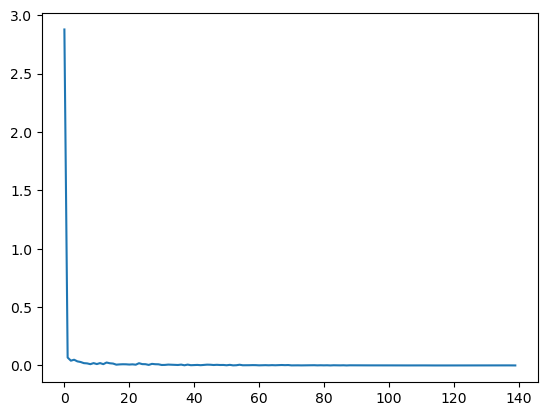

In [151]:
# Plot the losses
plt.plot(losses)

In [ ]:
# Log scale losses
ax = plt.figure()
ax.set_yscale('log')
plt.plot(losses)


In [ ]:

with torch.no_grad():
    model.eval()
    
    # Get a batch of data
    X_word, X_pos, X_char, X_casing, y_batch = next(iter(test_dataloader))
    
    # Convert to float
    # X_char = X_char.float()
    X_casing = X_casing.float()
    
    h_state, c_state = model.init_hidden(batch_size)
    
    print("Casing type:", X_casing.dtype)
    
    X_char = X_char.to(device)
    X_pos = X_pos.to(device)
    X_word = X_word.to(device)
    X_casing = X_casing.to(device)
    h_state = h_state.to(device)
    c_state = c_state.to(device)
    
    pred, h_state, c_state = model((X_char, X_pos, X_word, X_casing), h_state, c_state)
    
    pred = torch.argmax(pred, dim=2)
    
    print("Predictions shape:", pred.shape)
    print("Ground truth shape:", y_batch.shape)
    
    idx = 37
    
    print("Predictions:", pred[idx])
    print("Ground truth:", y_batch[idx])    
    

In [244]:
# Get item 24 from the loader
X_word, X_pos, X_char, X_casing, y_batch = next(iter(test_dataloader))

In [250]:
# Compute the accuracy
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    
    for X_word, X_pos, X_char, X_casing, y_batch in test_dataloader:
        X_casing = X_casing.float()
        
        h_state, c_state = model.init_hidden(X_word.shape[0])
        
        X_char = X_char.to(device)
        X_pos = X_pos.to(device)
        X_word = X_word.to(device)
        X_casing = X_casing.to(device)
        y_batch = y_batch.to(device)
        h_state = h_state.to(device)
        c_state = c_state.to(device)
        
        pred, h_state, c_state = model((X_char, X_pos, X_word, X_casing), h_state, c_state)
        
        pred = torch.argmax(pred, dim=2)
                
        # Count the number of correct predictions for labeled tokens. Ignore padding tokens.
        for i in range(len(y_batch)):
            for j in range(len(y_batch[i])):
                if y_batch[i][j] > 2:
                    total += 1
                    if y_batch[i][j] == pred[i][j]:
                        correct += 1
                        labeled_correct += 1
                        
        
print("Accuracy:", correct / total)

Accuracy: 0.9710789063487383


In [ ]:
# Compute precision, recall and F1 score with scikit-learn
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

predicts = []
ground_truths = []

with torch.no_grad():
    model.eval()
    
    for X_word, X_pos, X_char, X_casing, y_batch in train_dataloader:
        X_casing = X_casing.float()
        
        h_state, c_state = model.init_hidden(X_word.shape[0])
        
        X_char = X_char.to(device)
        X_pos = X_pos.to(device)
        X_word = X_word.to(device)
        X_casing = X_casing.to(device)
        y_batch = y_batch.to(device)
        h_state = h_state.to(device)
        c_state = c_state.to(device)
        
        pred, h_state, c_state = model((X_char, X_pos, X_word, X_casing), h_state, c_state)
        
        pred = torch.argmax(pred, dim=2)
        
        # Flatten the tensors
        y_batch = y_batch.view(-1)
        pred = pred.view(-1)
        
        # Ignore padding, start and end tokens
        # mask = (y_batch > 2)
        
        # y_batch = y_batch[mask]
        # pred = pred[mask]
        
        predicts.extend(pred.cpu().numpy())
        ground_truths.extend(y_batch.cpu().numpy())
        
print("F1 score:", f1_score(ground_truths, predicts, average='weighted'))
print("Precision:", precision_score(ground_truths, predicts, average='weighted'))
print("Recall:", recall_score(ground_truths, predicts, average='weighted'))

In [285]:
labels = list(tag_vocab.ind2word.values())

print(classification_report(ground_truths, predicts, target_names=labels, zero_division=0, labels=range(len(labels))))

              precision    recall  f1-score   support

       <pad>       1.00      1.00      1.00   3022358
     <start>       1.00      1.00      1.00     12070
       <end>       1.00      1.00      1.00     12070
       <unk>       0.00      0.00      0.00         0
           O       1.00      1.00      1.00    168832
       B-NEG       0.99      1.00      1.00      4281
       I-NEG       0.00      0.00      0.00         0
       E-NEG       1.00      0.93      0.97        91
       B-UNC       1.00      0.99      0.99       455
       I-UNC       0.00      0.00      0.00         5
       E-UNC       0.99      0.98      0.99       214
      B-NSCO       0.99      1.00      0.99      4063
      I-NSCO       0.98      0.96      0.97      6579
      E-NSCO       0.87      0.95      0.91      1965
      B-USCO       0.98      0.98      0.98       449
      I-USCO       0.98      0.99      0.98      1216
      E-USCO       0.93      0.77      0.84       112

   micro avg       1.00   